In [31]:
from keras.preprocessing.image import ImageDataGenerator


batch_size = 64

# Configuration for test data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    '/Users/pranavsukumaran/Desktop/Fall/Machine_Learning/project_test/fer_data/test',  
    target_size=(197, 197),
    batch_size=1,
    color_mode="rgb",  # this should be "rgb" for resnet
    class_mode='categorical',
    shuffle=False  
)

Found 3589 images belonging to 7 classes.


In [32]:
from keras.models import load_model

model_path = '/Users/pranavsukumaran/Desktop/Fall/Machine_Learning/project_test/pretrained_Resnet.h5'
model = load_model(model_path)



In [30]:
def compute_saliency_map(model, image, class_idx):
    # Convert image to TensorFlow tensor 
    image_tensor = tf.convert_to_tensor(image)
    
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = predictions[:, class_idx]

    gradients = tape.gradient(loss, image_tensor)
    return gradients


In [4]:
def normalize_saliency_map(saliency_map):
    saliency_map = np.abs(saliency_map)
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    return saliency_map


In [22]:
def superimpose_saliency_map(original_image, saliency_map):
    saliency_map = np.squeeze(saliency_map)
    # Convert to an RGB heatmap
    heatmap = np.uint8(255 * saliency_map) 
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if len(original_image.shape) == 2 or original_image.shape[2] == 1:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * 0.4 + original_image
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img





In [14]:
def visualize_all(original_image, saliency_map, superimposed_image):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Saliency Map')
    plt.imshow(saliency_map.squeeze(), cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Superimposed Image')
    plt.imshow(superimposed_image.squeeze())
    plt.axis('off')

    plt.show()


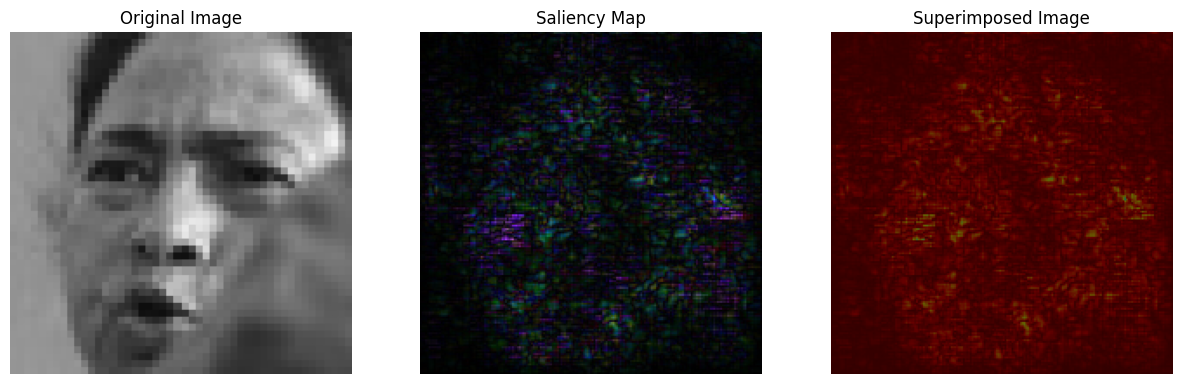

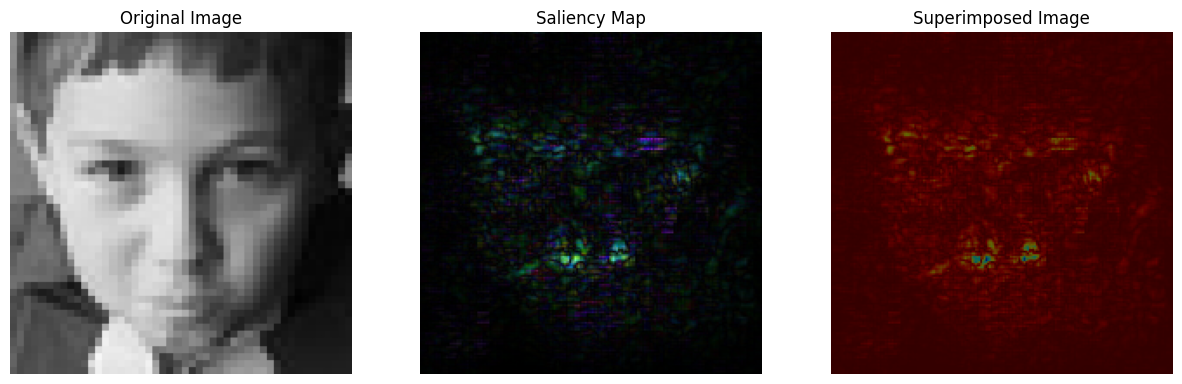

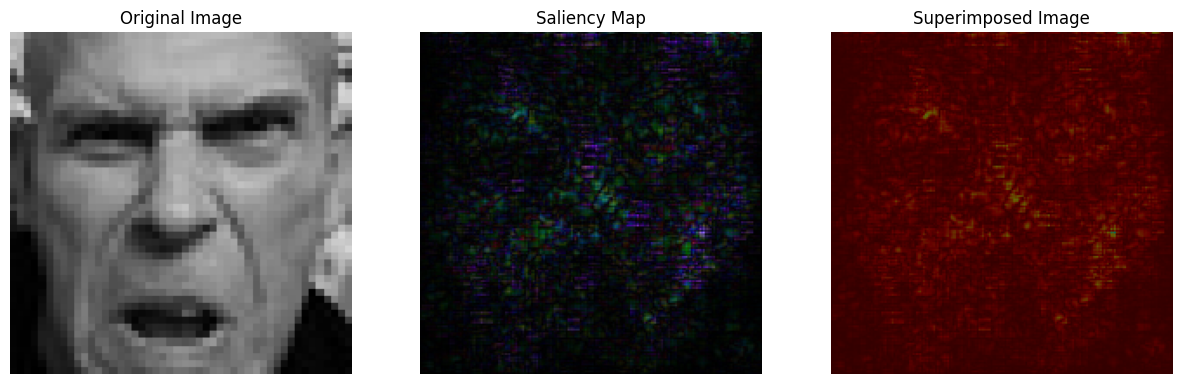

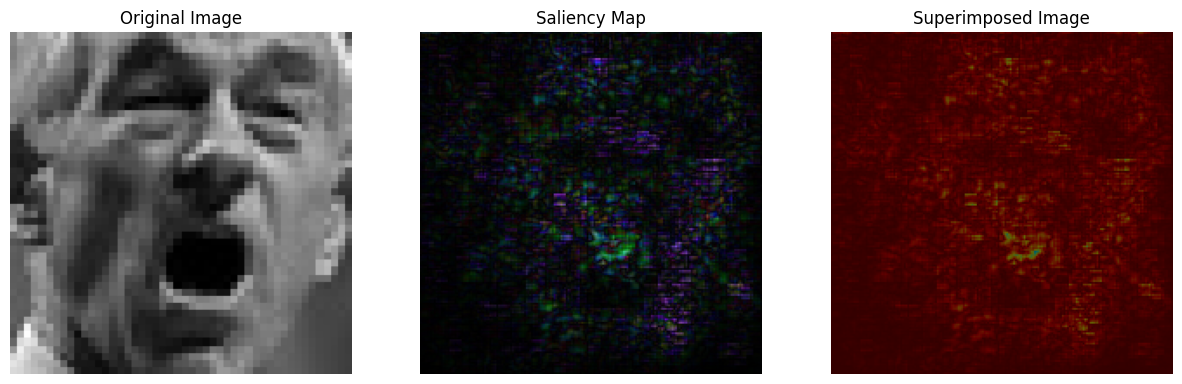

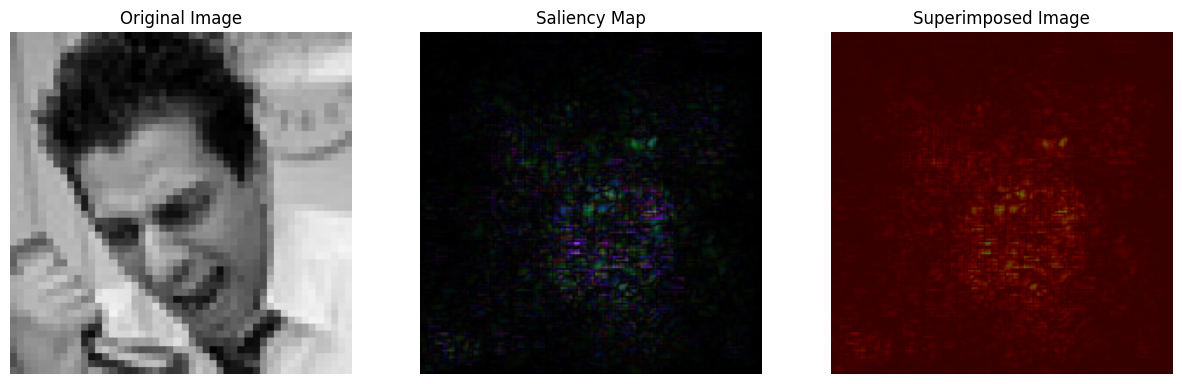

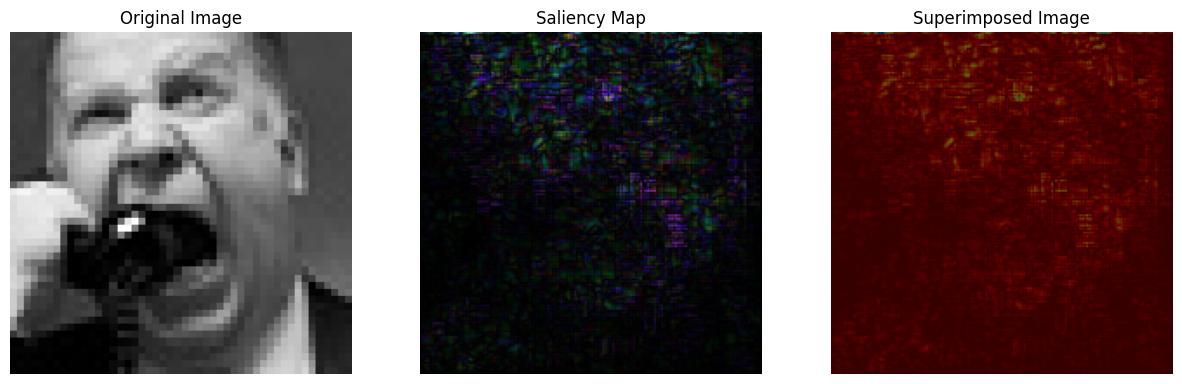

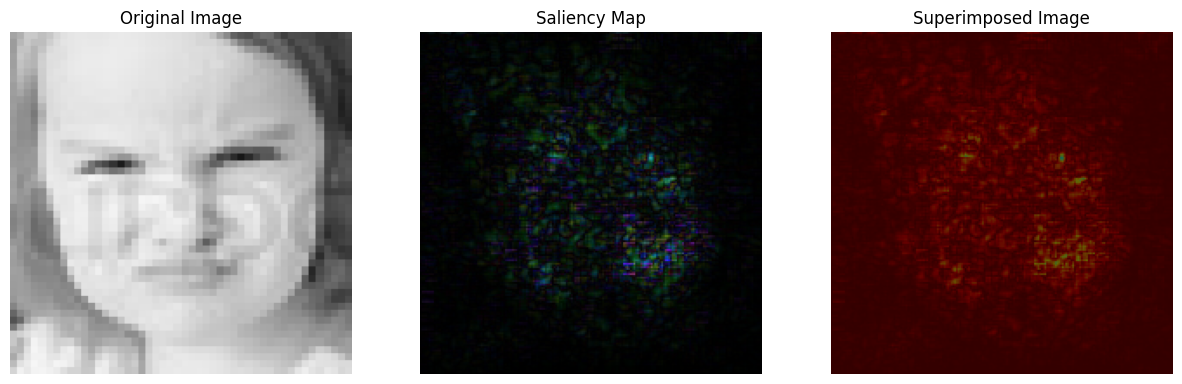

In [23]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

num_images = 7  

for i in range(num_images):
    image, label = next(test_generator)
    class_idx = np.argmax(label)
    saliency = compute_saliency_map(model, image, class_idx)
    normalized_saliency = normalize_saliency_map(saliency)
    superimposed_image = superimpose_saliency_map(image[0], normalized_saliency)
    visualize_all(image[0], normalized_saliency, superimposed_image)


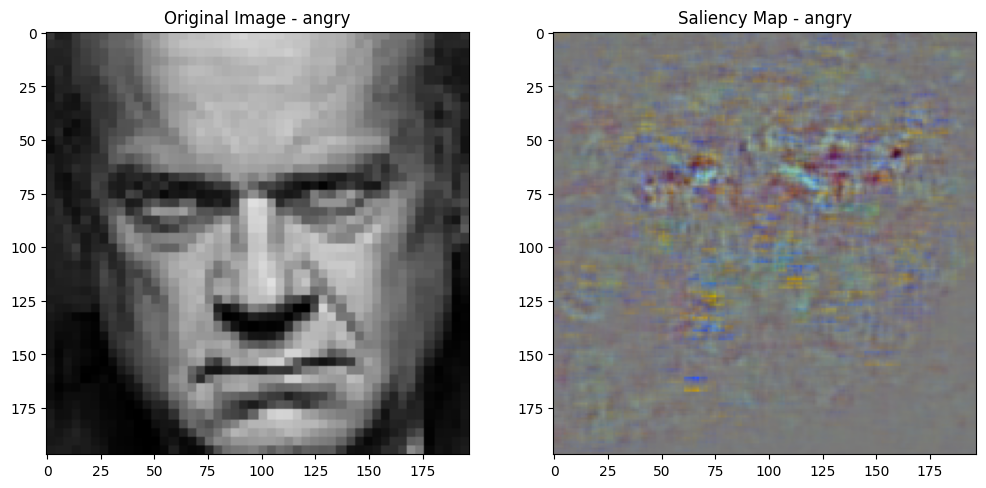

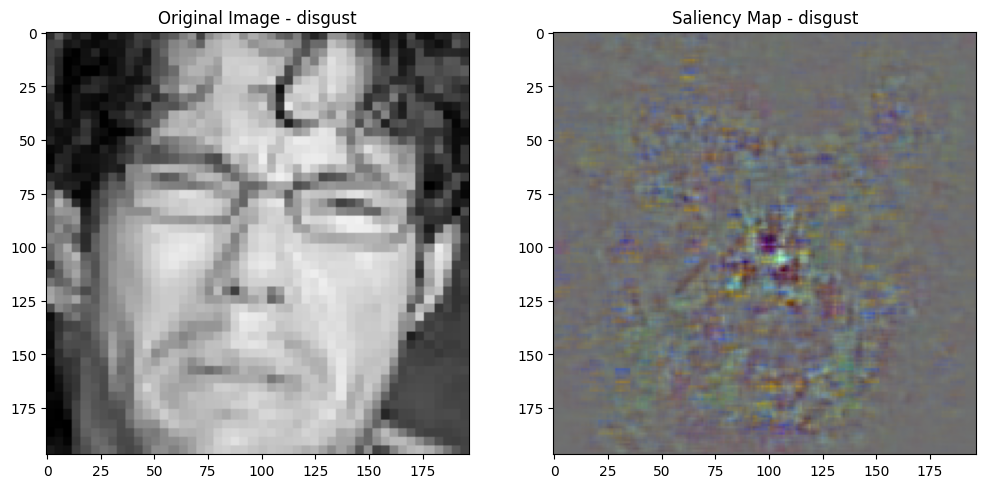

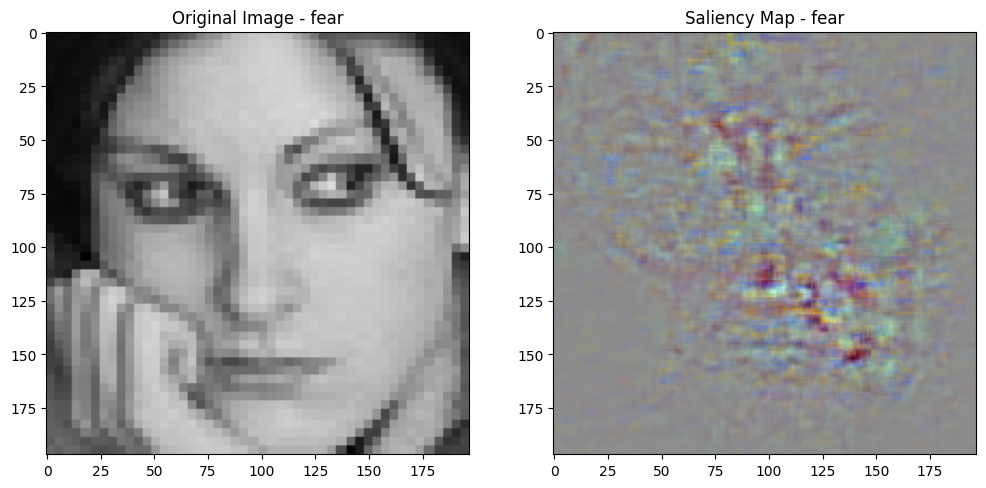

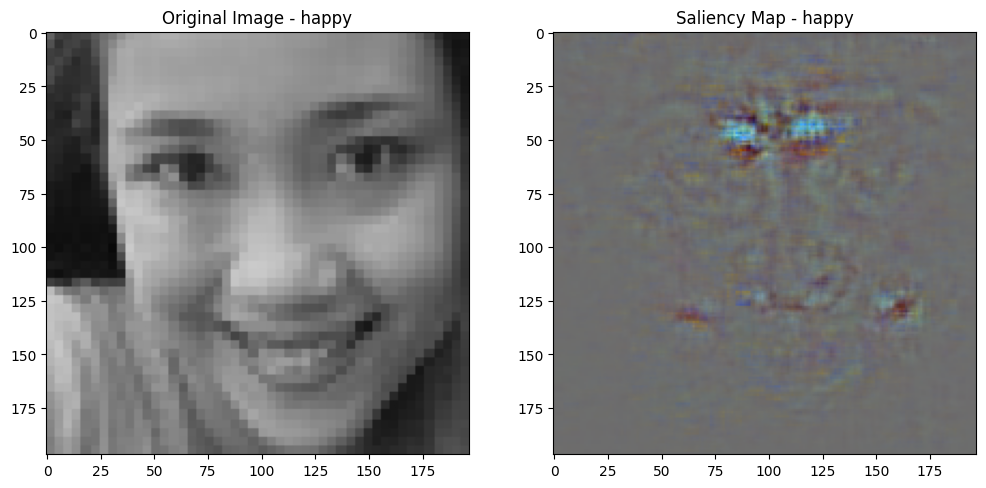

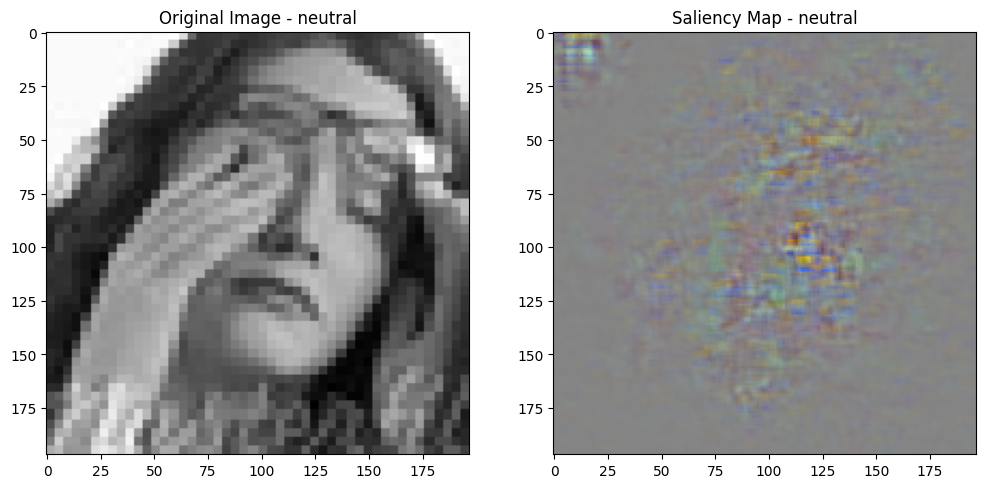

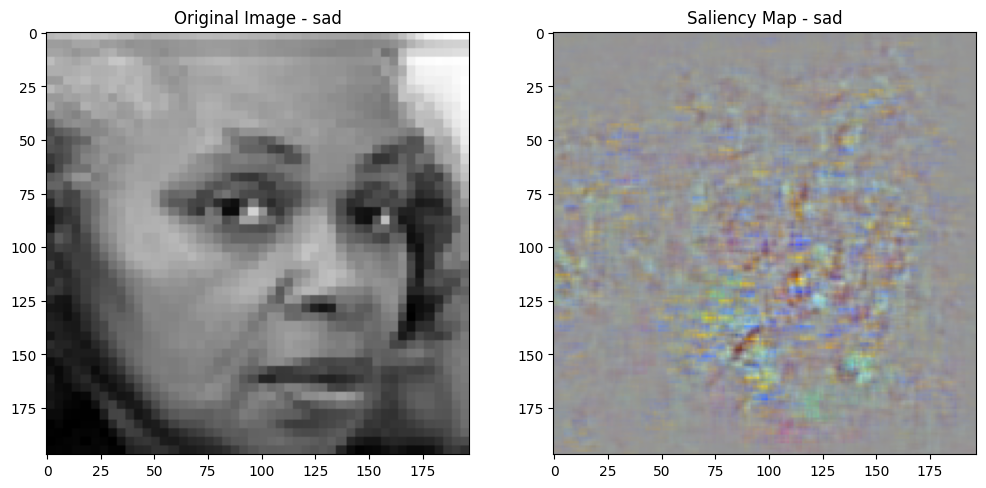

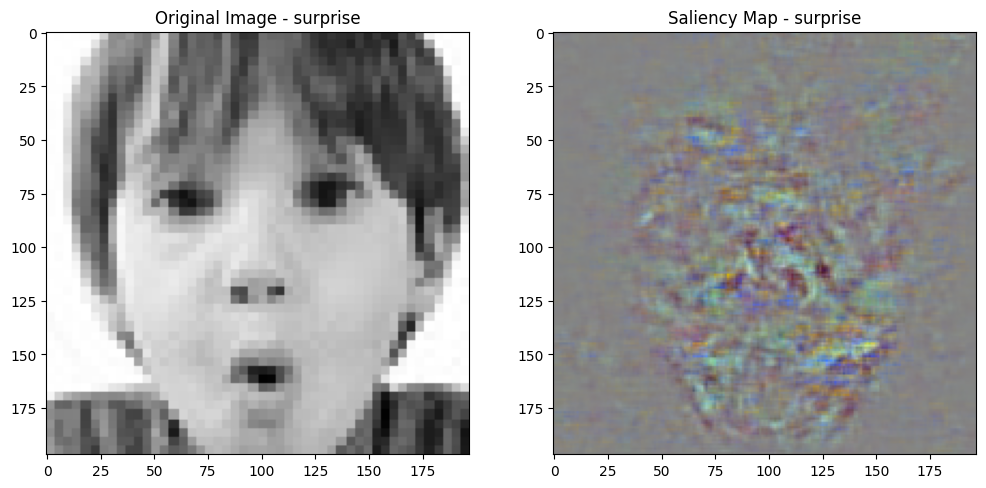

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input


model = load_model('/Users/pranavsukumaran/Desktop/Fall/Machine_Learning/project_test/pretrained_Resnet.h5')

class_labels = list(test_generator.class_indices.keys())

# Process one image for each class
for class_label in class_labels:
    # Find an image from the specified class
    for x_batch, y_batch in test_generator:
        if np.argmax(y_batch[0]) == test_generator.class_indices[class_label]:
            # Convert the batch to a TensorFlow tensor
            x_batch_tensor = tf.convert_to_tensor(x_batch)

            # Compute the saliency map
            with tf.GradientTape() as tape:
                tape.watch(x_batch_tensor)
                predictions = model(x_batch_tensor)
                loss = predictions[:, np.argmax(y_batch[0])]

            gradient = tape.gradient(loss, x_batch_tensor)
            gradient = np.squeeze(gradient.numpy())  # Convert tensor back to numpy for visualization
            gradient = (gradient - gradient.min()) / (gradient.max() - gradient.min())
            gradient = (gradient * 255).astype(np.uint8)

            # Display the original image and the saliency map
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np.squeeze(x_batch[0]))
            plt.title(f'Original Image - {class_label}')

            plt.subplot(1, 2, 2)
            plt.imshow(gradient, cmap='viridis')
            plt.title(f'Saliency Map - {class_label}')

            plt.show()
            break


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())



2023-12-14 13:45:42.084163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3589/3589 [==============================] - 312s 87ms/step


In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df.drop(columns='support', inplace=True)
final_metrics_df = report_df

final_metrics_df

precision    recall  f1-score
angry          0.609284  0.674518  0.640244
disgust        0.861111  0.553571  0.673913
fear           0.646526  0.431452  0.517533
happy          0.875541  0.903911  0.889500
neutral        0.647516  0.686985  0.666667
sad            0.578313  0.661562  0.617143
surprise       0.841026  0.790361  0.814907
accuracy       0.709390  0.709390  0.709390
macro avg      0.722760  0.671766  0.688558
weighted avg   0.712385  0.709390  0.706431